In [6]:
# ──────────────────────────────────────────────────────────────────────────────
# CONTEXT / ASSUMPTIONS
# • You launched Jupyter via Great Lakes OnDemand (or an interactive job),
#   NOT on a login node.
# • You may be using the “Python 3 (ipykernel)” kernel OR one of your conda kernels
#   (“cellpose3 (GPU)” or “cellpose4 (GPU)”). For visualization, any is fine.
# • We DO NOT run Cellpose here; we only READ results already written by SLURM jobs.
# • Data layout on Turbo (as used by your pipeline):
#     /nfs/turbo/umms-parent/cellpose_gpu_test/
#       ├── images/
#       │     ├── WT/    ← .tif input images (merged DAPI+LHX6+PCDH19), often C×Y×X or Y×X (uint16)
#       │     └── KO/
#       └── results/
#             ├── WT/
#             │     ├── cellpose3/  ← files like <stem>_cp_masks.tif, <stem>_flows.npy, <stem>_cp_outlines.png
#             │     └── cellpose4/  ← same pattern
#             └── KO/
#                   ├── cellpose3/
#                   └── cellpose4/
#
# • Mask filenames follow the Cellpose defaults created by your SLURM wrapper:
#     <image_stem>_cp_masks.tif        (binary/label mask)
#     <image_stem>_flows.npy           (flows/probabilities)
#     <image_stem>_cp_outlines.png     (quick-look overlay)
#
# • This notebook only reads/plots images and masks; it doesn’t alter your conda envs.
#   If matplotlib/tifffile aren’t present in your kernel, you can `!pip install --user ...`
#   which installs into ~/.local, NOT into your conda envs.
# ──────────────────────────────────────────────────────────────────────────────

import sys, os, platform
print("Python:", sys.version.split()[0], "| Executable:", sys.executable)
print("Host  :", platform.node())
print("CWD   :", os.getcwd())

Python: 3.10.9 | Executable: /sw/pkgs/arc/python3.10-anaconda/2023.03/bin/python
Host  : gl3150.arc-ts.umich.edu
CWD   : /home/elcrespo/Desktop/githubprojects/cellpose_on_umich_hpc/notebooks


In [7]:
# ──────────────────────────────────────────────────────────────────────────────
# SELECT WHAT YOU WANT TO LOOK AT
# Set COND = "WT" or "KO" to choose which condition’s images/results to explore.
# Update TEST_ROOT only if your Turbo test directory changes.
# ──────────────────────────────────────────────────────────────────────────────

from pathlib import Path

TEST_ROOT = Path("/nfs/turbo/umms-parent/cellpose_gpu_test")  # fixed external test root used in SLURM runs
COND      = "WT"                                              # change to "KO" when needed

# Input images (merged max-projection TIFFs)
IMG_DIR = TEST_ROOT / "images" / COND

# Output masks/overlays from your SLURM jobs (one folder per Cellpose version)
CP3_DIR = TEST_ROOT / "results" / COND / "cellpose3"          # cp3 (cyto3 model) results
CP4_DIR = TEST_ROOT / "results" / COND / "cellpose4"          # cp4 (cpsam model) results

print("Images dir:", IMG_DIR)
print("cp3 dir   :", CP3_DIR)
print("cp4 dir   :", CP4_DIR)
print("Sample images:", list(sorted(IMG_DIR.glob("*.tif")))[:5])

Images dir: /nfs/turbo/umms-parent/cellpose_gpu_test/images/WT
cp3 dir   : /nfs/turbo/umms-parent/cellpose_gpu_test/results/WT/cellpose3
cp4 dir   : /nfs/turbo/umms-parent/cellpose_gpu_test/results/WT/cellpose4
Sample images: [PosixPath('/nfs/turbo/umms-parent/cellpose_gpu_test/images/WT/Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F0__max__LHX6+PCDH19+DAPI.tif'), PosixPath('/nfs/turbo/umms-parent/cellpose_gpu_test/images/WT/Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F1__max__LHX6+PCDH19+DAPI.tif'), PosixPath('/nfs/turbo/umms-parent/cellpose_gpu_test/images/WT/Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F2__max__LHX6+PCDH19+DAPI.tif'), PosixPath('/nfs/turbo/umms-parent/cellpose_gpu_test/images/WT/Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F3__max__LHX6+PCDH19+DAPI.tif'), PosixPath('/nfs/turbo/umms-parent/cellpose_gpu_test/images/WT/Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F

In [8]:
# ──────────────────────────────────────────────────────────────────────────────
# HELPER: prepare_for_imshow
#   • Accepts arrays shaped as:
#       - (Y, X)            → grayscale image, return (arr, {'cmap':'gray'})
#       - (C, Y, X)         → channels-first; if C ∈ {3,4}, moves to (Y, X, C)
#       - (Y, X, C)         → already RGB(A), return as-is
#       - other 3D (e.g., Z,Y,X) → max-intensity projection along axis 0
#   • Returns (display_array, kwargs) suitable for plt.imshow.
#
# HELPER: normalize_image
#   • Performs robust percentile-based contrast stretching (like ImageJ “Auto”).
#   • Critical for 16-bit microscopy data where raw intensities are dim.
#
# HELPER: load_mask
#   • Loads <stem>_cp_masks.tif if present, otherwise returns None.
# ──────────────────────────────────────────────────────────────────────────────

import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread

def prepare_for_imshow(arr):
    a = np.asarray(arr)
    if a.ndim == 2:
        return a, dict(captured=True, cmap="gray")  # 2D grayscale

    if a.ndim == 3:
        # channels-first C×Y×X with 3/4 channels → move to Y×X×C
        if a.shape[0] in (3, 4) and a.shape[-1] not in (3, 4):
            a = np.moveaxis(a, 0, -1)
        # channels-last Y×X×C with 3/4 channels → already RGB(A)
        if a.shape[-1] in (3, 4):
            return a, dict(captured=True)          # color image (no cmap)
        # other 3D (e.g. Z×Y×X) → max projection
        return a.max(axis=0), dict(captured=True, cmap="gray")

    # Fallback: squeeze; if still 3D, project
    a = np.squeeze(a)
    if a.ndim == 2:
        return a, dict(captured=True, cmap="gray")
    if a.ndim == 3:
        return a.max(axis=0), dict(captured=True, cmap="gray")
    return a, dict(captured=True, cmap="gray")

def normalize_image(img, lower=1.0, upper=99.8):
    x = np.asarray(img, dtype=np.float32)
    # Percentile clipping for robust contrast stretch
    vmin, vmax = np.percentile(x, (lower, upper))
    if vmax <= vmin:  # extreme or constant image; avoid division by zero
        return (x - x.min()) / (x.max() - x.min() + 1e-6)
    return np.clip((x - vmin) / (vmax - vmin + 1e-6), 0, 1)

def load_mask(res_dir: Path, stem: str):
    p = res_dir / f"{stem}_cp_masks.tif"
    return imread(p) if p.exists() else None

Viewing: Exp68_Slide1_IGI_PCE_VMIX1_DIV24_F_488_LHX6_568_HA_FusionStitcher_F0__max__LHX6+PCDH19+DAPI.tif
  dtype/min/max: uint16 0 65535
Masks present? -> cp3: True | cp4: True


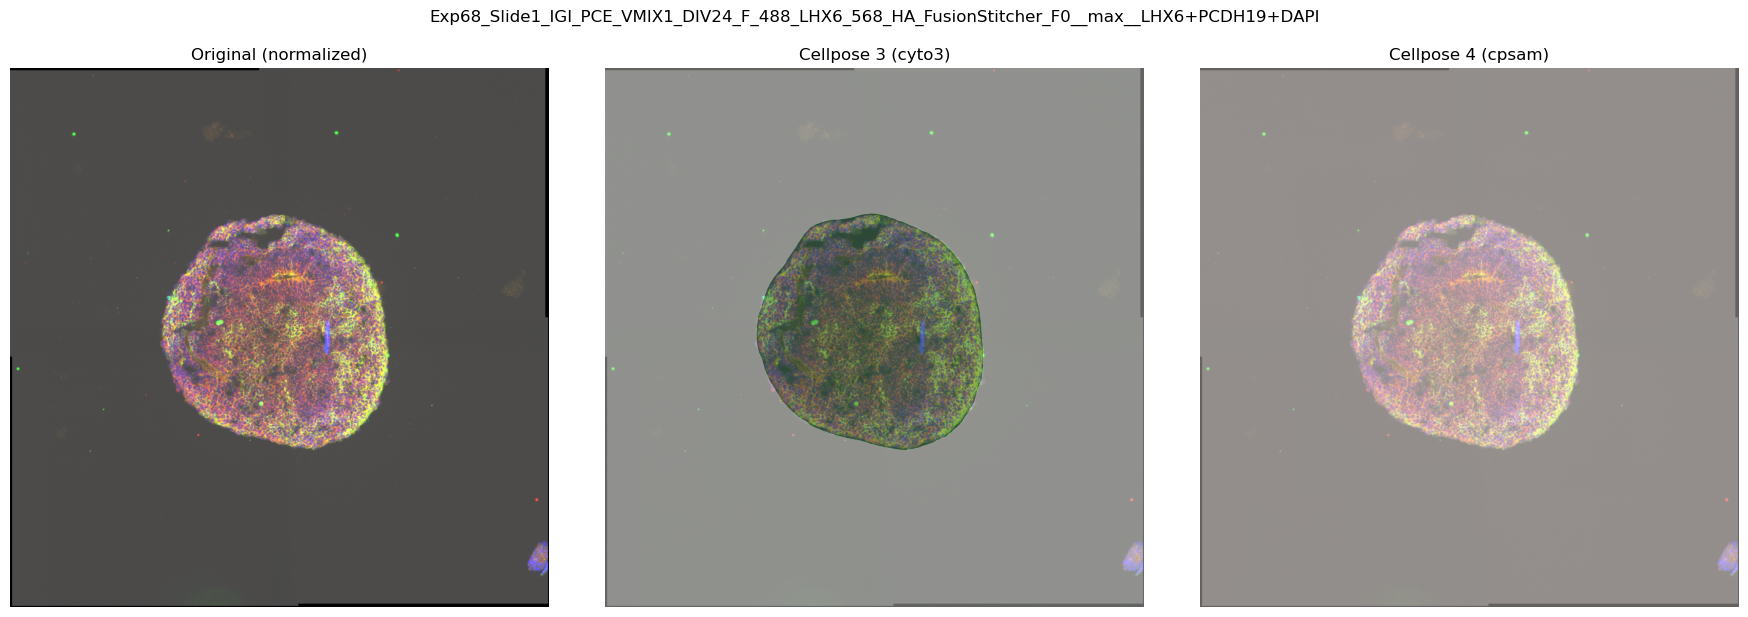

In [9]:
# ──────────────────────────────────────────────────────────────────────────────
# SINGLE-IMAGE VIEW
# • Picks one input .tif from IMG_DIR.
# • Prepares and normalizes for display (so you see the organoid clearly).
# • Loads cp3/cp4 masks if present and overlays them:
#     - cp3 in green (cyto3 model from Cellpose v3)
#     - cp4 in red   (cpsam model from Cellpose v4)
# • This is read-only visualization; nothing is written back to disk.
# ──────────────────────────────────────────────────────────────────────────────

# Choose an image to visualize (change index as needed)
img_paths = sorted(IMG_DIR.glob("*.tif"))
assert len(img_paths) > 0, "No .tif files found in IMG_DIR"
img_path = img_paths[0]

# Load raw image (usually uint16, possibly C×Y×X “merged” channels)
raw = imread(img_path)

# Prepare for display (RGB or grayscale) and apply robust contrast stretch
disp, imshow_kwargs = prepare_for_imshow(raw)
disp = normalize_image(disp)  # improves visibility for 16-bit data

# Load corresponding masks from cp3/cp4 result folders
m3 = load_mask(CP3_DIR, img_path.stem)   # None if cp3 run not done for this image
m4 = load_mask(CP4_DIR, img_path.stem)   # None if cp4 run not done for this image

print("Viewing:", img_path.name)
print("  dtype/min/max:", raw.dtype, raw.min(), raw.max())
print("Masks present? -> cp3:", m3 is not None, "| cp4:", m4 is not None)

# Plot original + overlays side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
ax[0].set_title("Original (normalized)"); ax[0].axis("off")

ax[1].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
if m3 is not None:
    ax[1].imshow((m3 > 0), cmap="Greens", alpha=0.40)
ax[1].set_title("Cellpose 3 (cyto3)");    ax[1].axis("off")

ax[2].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
if m4 is not None:
    ax[2].imshow((m4 > 0), cmap="Reds", alpha=0.40)
ax[2].set_title("Cellpose 4 (cpsam)");    ax[2].axis("off")

plt.suptitle(img_path.stem, y=1.02)
plt.tight_layout()
plt.show()

Found 6 images in /nfs/turbo/umms-parent/cellpose_gpu_test/images/WT


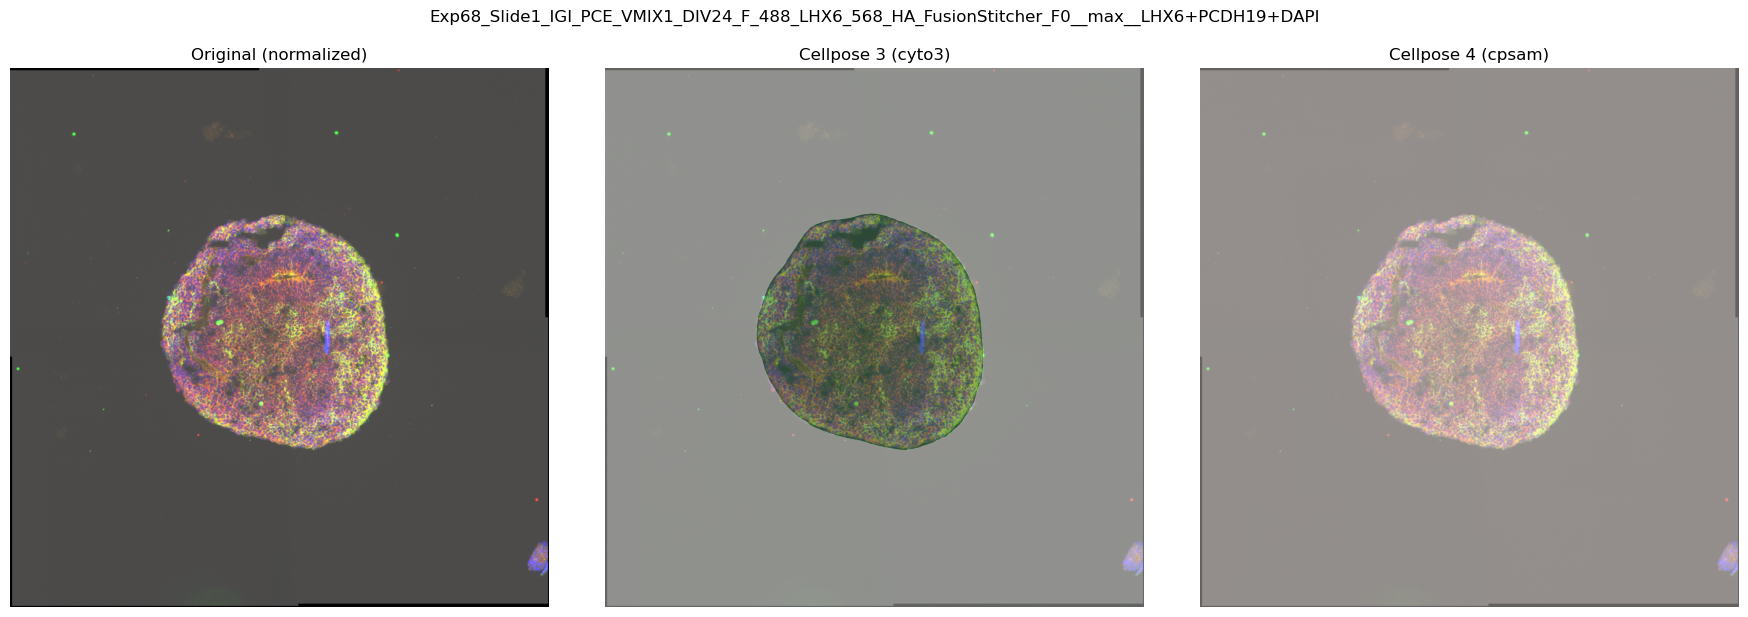

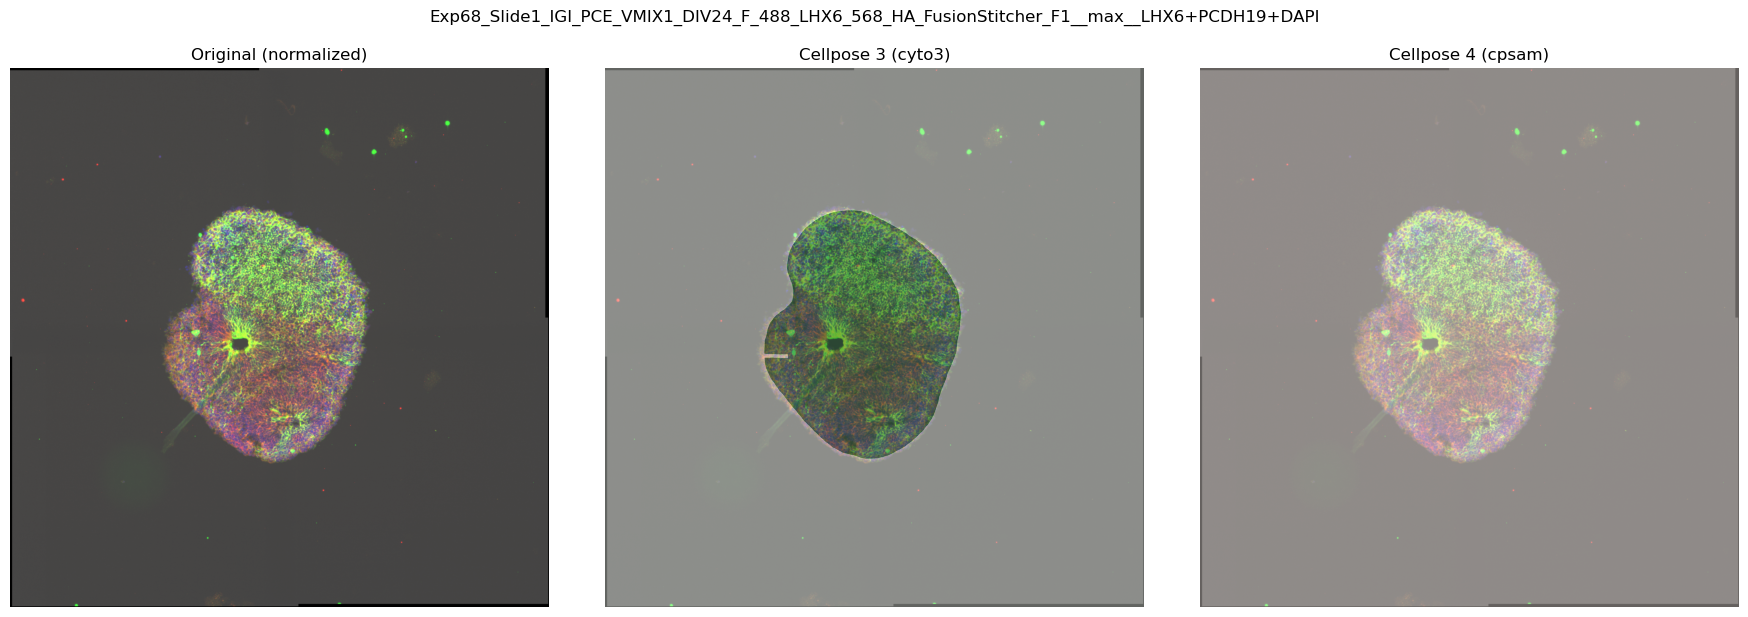

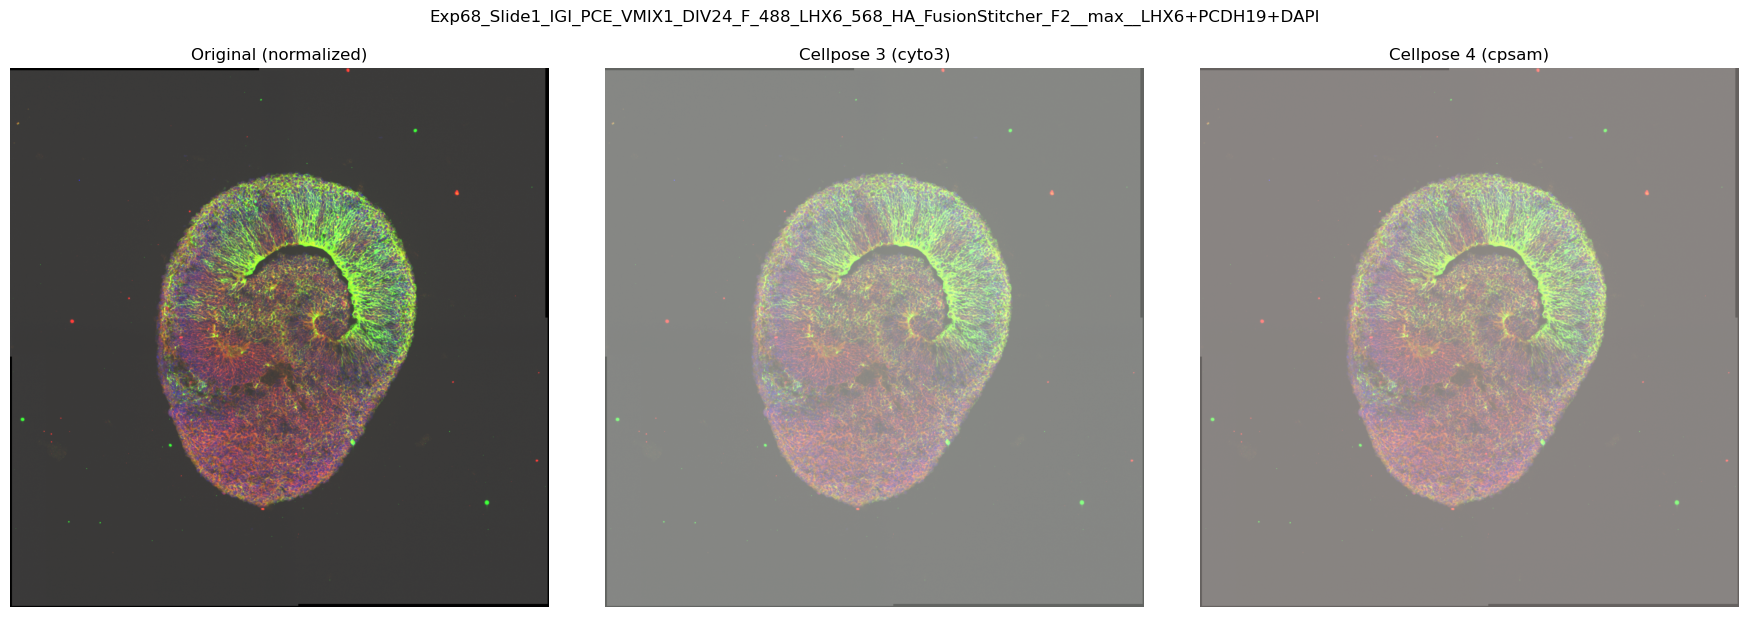

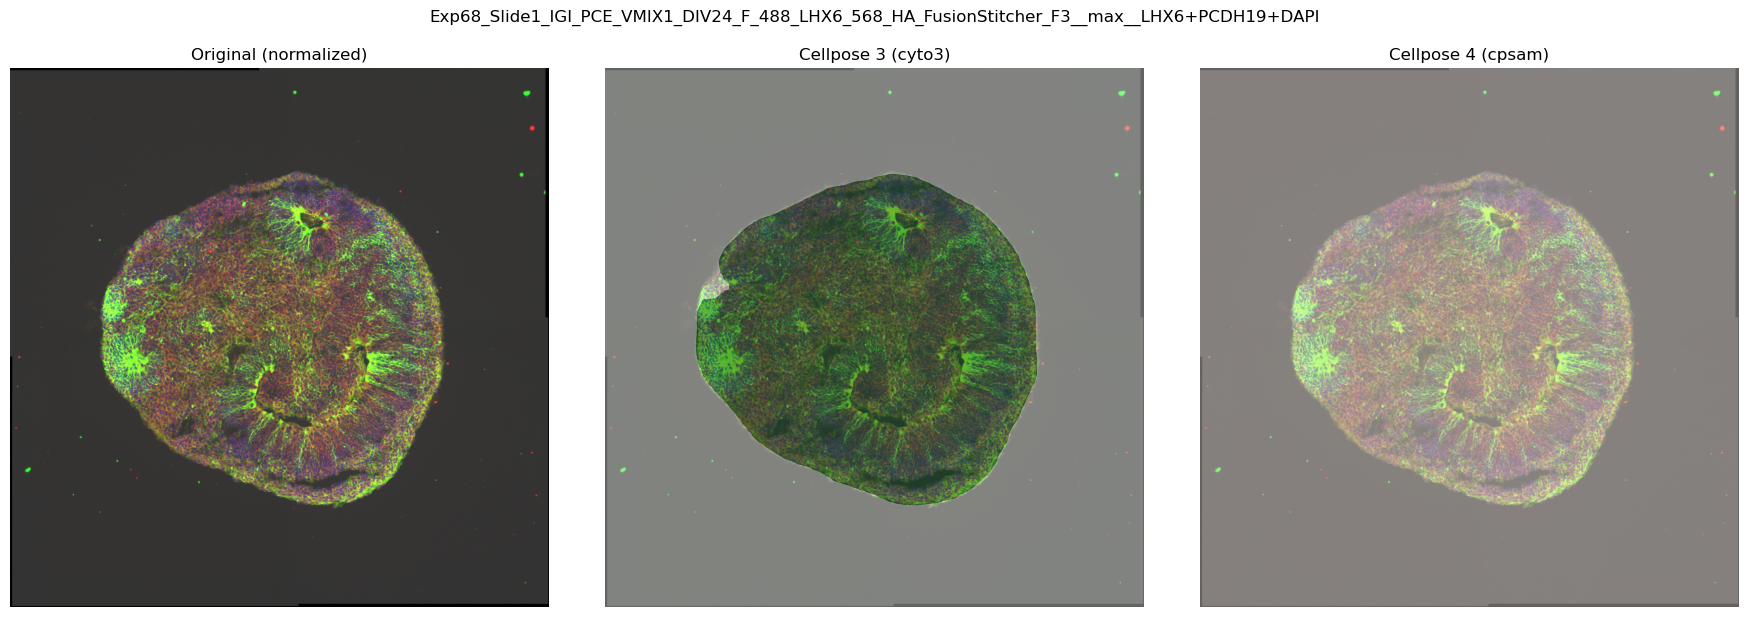

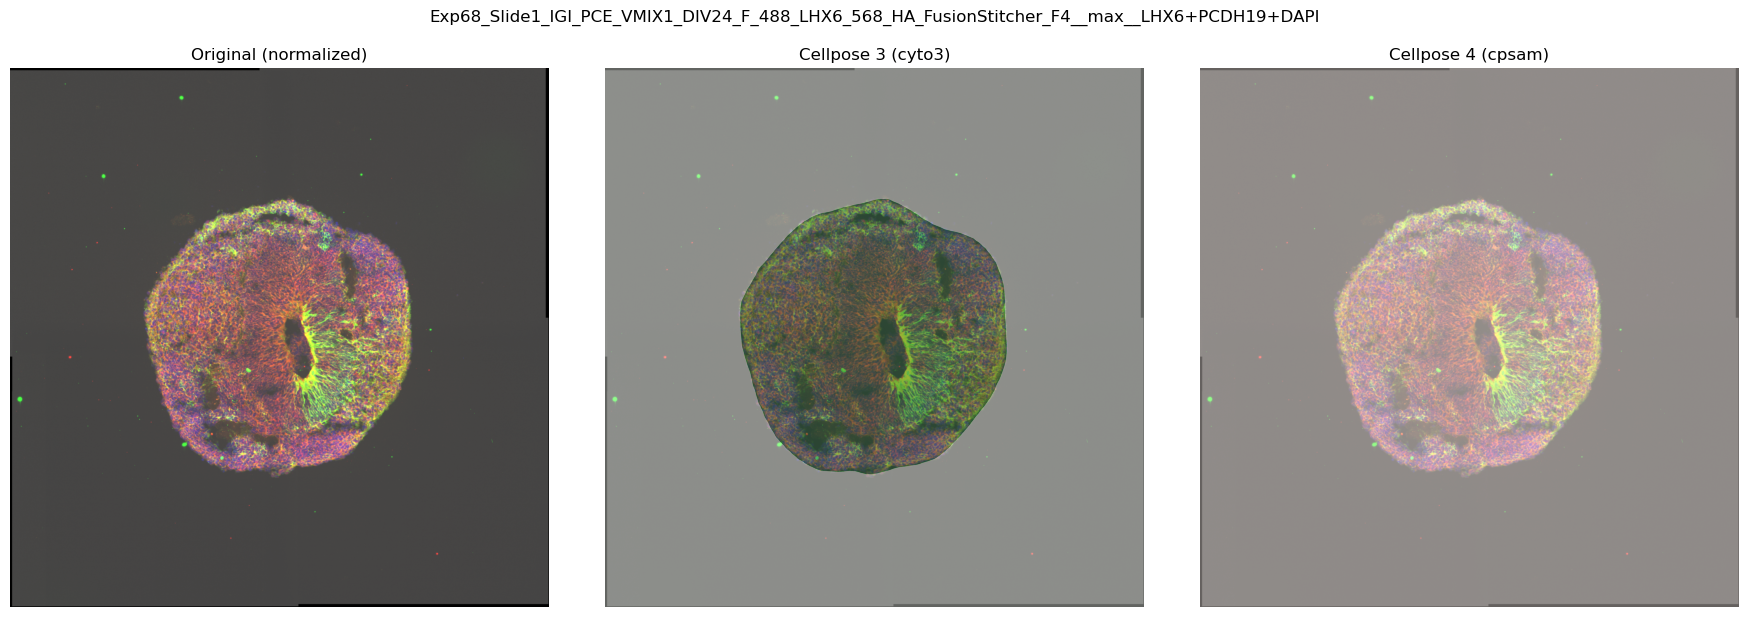

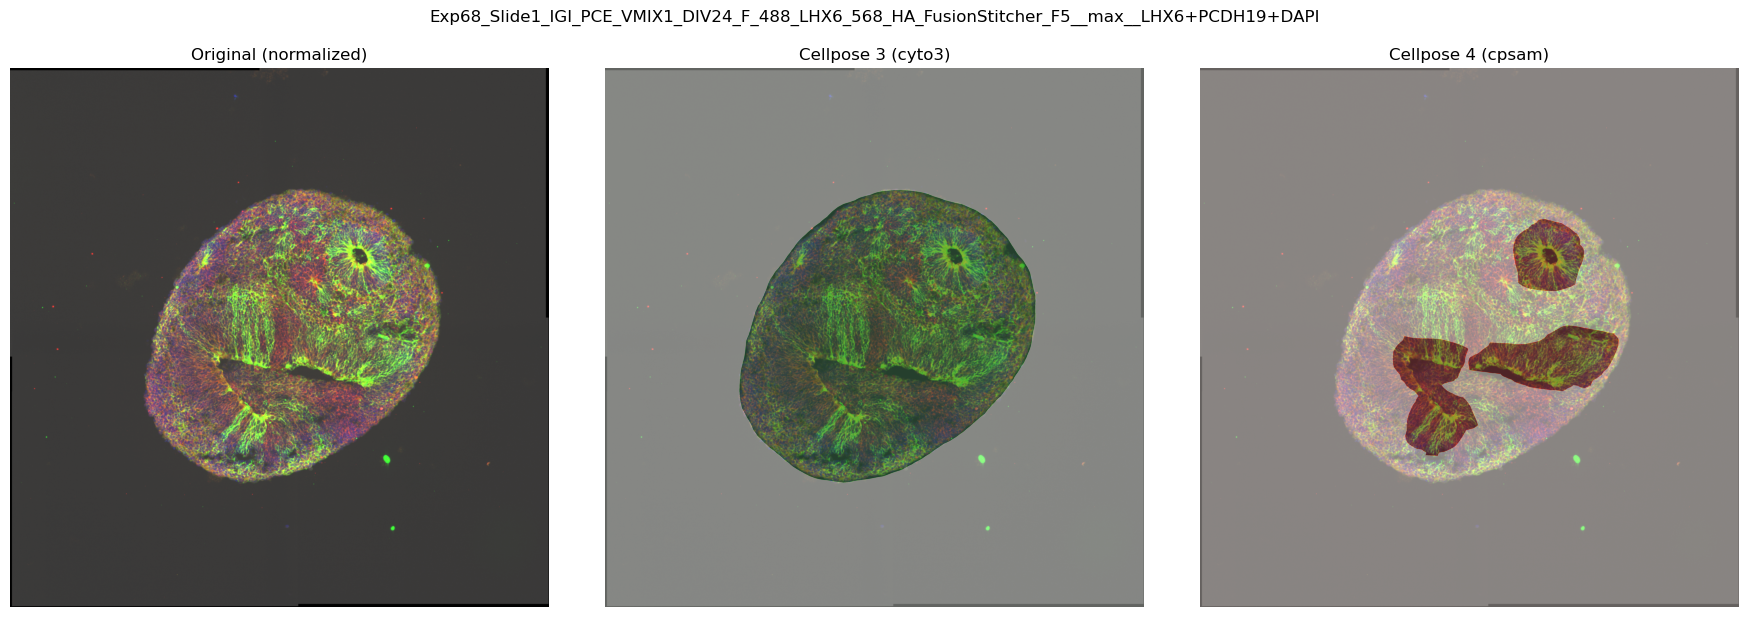

In [10]:
# ──────────────────────────────────────────────────────────────────────────────
# BATCH QC VIEW
# • Iterates through a subset of images (change 'subset' as needed).
# • For each, displays original + cp3 overlay + cp4 overlay.
# • Useful for scanning differences between v3 and v4 segmentations quickly.
# ──────────────────────────────────────────────────────────────────────────────

all_imgs = sorted(IMG_DIR.glob("*.tif"))
print(f"Found {len(all_imgs)} images in {IMG_DIR}")

# Pick a subset for speed; set to all_imgs to see everything
subset = all_imgs[:6]

for p in subset:
    raw = imread(p)
    disp, imshow_kwargs = prepare_for_imshow(raw)
    disp = normalize_image(disp)

    m3 = load_mask(CP3_DIR, p.stem)
    m4 = load_mask(CP4_DIR, p.stem)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    ax[0].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
    ax[0].set_title("Original (normalized)"); ax[0].axis("off")

    ax[1].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
    if m3 is not None:
        ax[1].imshow((m3>0), cmap="Greens", alpha=0.40)
    ax[1].set_title("Cellpose 3 (cyto3)"); ax[1].axis("off")

    ax[2].imshow(disp, **{k:v for k,v in imshow_kwargs.items() if k != 'captured'})
    if m4 is not None:
        ax[2].imshow((m4>0), cmap="Reds", alpha=0.40)
    ax[2].set_title("Cellpose 4 (cpsam)"); ax[2].axis("off")

    plt.suptitle(p.stem, y=1.02)
    plt.tight_layout()
    plt.show()